In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import figure

%load_ext autoreload
%autoreload 2

sys.path.append("../library/")

from define_networks import *
from functions import *

# Neural networks approximating linear operators

This notebook approximates the linear operator $U_{t}$ from the **heat equation** using data obtain by using *FEniCS* and by the *analytical* solution of the PDE

### Proposed Heat Equation

\begin{equation}
    \begin{cases}
    u_{t} = u_{xx} + u_{yy}, \quad \quad (x,y) \in \Omega \\
    u' = 0, \quad\quad\quad\quad\quad\quad (x,y) \in \partial \Omega\\
    \end{cases}
\end{equation}
#### Initial Conditions
\begin{equation}
        U(x,y,0) =  \cos{(\pi x)}\cos{(\pi y)}
\end{equation}

#### Exact Solution: 
\begin{equation}
        U(x,y,t) = \cos{(\pi x)}\cos{(\pi y)} e^{-2\pi^{2}t}
\end{equation}

In [2]:
## parameters
random_state = 1

# dimension of the problem
n_dim = 50
n_steps_epoch = 100
# training samples
n_samples_train = 10000
n_per_axis = 250
n_samples_test = 100

# neural network parameters
NET_ACTIVATIONS = tf.nn.elu
NET_LAYERS = 3
NET_NEURONS_PER_LAYER = 8

# NET_LEARNING_RATE = 1e-2
NET_EPOCHS = 200
NET_BATCH_SIZE = 64
# NET_DECAY_RATE = NET_LEARNING_RATE/NET_EPOCHS


# Analytical Solution data

In [3]:
# Define exact solution of the heat eqn:

def analytical_solution(x,y,t):
    return np.exp(-2*t*(math.pi)**2)*np.cos(math.pi*x)*np.cos(math.pi*y)

# Define axis:
x_axis = np.linspace(0,1, num=n_per_axis + 1)
y_axis = np.linspace(0,1,num=n_per_axis + 1)
t_axis = np.linspace(0,0.01, num =101)

delta_t = t_axis[1]
delta_x = x_axis[1]
delta_y = y_axis[1]

# Define exact solution for U & Ut using the analytical solution stated above
xx, yy, tt = np.meshgrid(x_axis, y_axis, t_axis, sparse=False)
U_exact =  analytical_solution(xx, yy, tt)
# Compute (Ut+1)-(Ut)
Ut_exact = np.diff(U_exact)

print("delta_t =", delta_t)
print("delta_x =", delta_x)
print("delta_y =", delta_y)
print("x_axis shape = ", x_axis.shape)
print("y_axis shape = ", y_axis.shape)
print("t_axis shape =", t_axis.shape)
print("U_exact shape =", U_exact.shape)
print("Ut_exact shape =", Ut_exact.shape)



delta_t = 0.0001
delta_x = 0.004
delta_y = 0.004
x_axis shape =  (251,)
y_axis shape =  (251,)
t_axis shape = (101,)
U_exact shape = (251, 251, 101)
Ut_exact shape = (251, 251, 100)


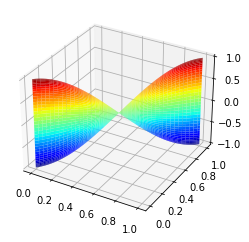

xx shape =  (251, 251, 101)
yy shape =  (251, 251, 101)
tt shape = (251, 251, 101)
U_exact shape = (251, 251, 101)
Ut_exact shape = (251, 251, 100)


In [4]:
#Plotting initial conditions

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_axis,y_axis, U_exact[:,:,0], cmap=cm.jet)
plt.show()

print("xx shape = ", xx.shape)
print("yy shape = ", yy.shape)
print("tt shape =", tt.shape)
print("U_exact shape =", U_exact.shape)
print("Ut_exact shape =", Ut_exact.shape)

In [5]:
# Generating the arrays U and Ut to train - Functions can be found on library/functions.py
# Linear combination of different operators

U_train3 = reshape_U(U_exact[:,:,70],n=n_per_axis)
Ut_train3 = get_Ut(U_exact[:,:,70],U_exact[:,:,71], n = n_per_axis) 


U_train1 = reshape_U(U_exact[:,:,2], n=n_per_axis) + U_train3
U_train2 = reshape_U(U_exact[:,:,50], n=n_per_axis) + U_train3

Ut_train1 = get_Ut(U_exact[:,:,2],U_exact[:,:,3], n = n_per_axis) + Ut_train3
Ut_train2 = get_Ut(U_exact[:,:,50],U_exact[:,:,51], n = n_per_axis) + Ut_train3

U_train = np.append(U_train1,U_train2, axis = 0)
Ut_train = np.append(Ut_train1,Ut_train2, axis = 0)

print("Ut shape:", Ut_train.shape)
print("U shape:", U_train.shape)

#Reordering
U_train , Ut_train = randomize_unision(U_train, Ut_train)


Ut shape: (126002,)
U shape: (126002, 5)


In [6]:
# define network model
dim_in = 5
dim_out = 1
network = ModelBuilder.define_feedforward_model(activation=NET_ACTIVATIONS,
                                             name="linearoperatorsolver",
                                             n_layers=NET_LAYERS,
                                             n_dim_per_layer=NET_NEURONS_PER_LAYER,
                                             n_input_dimensions=dim_in,
                                             n_output_dimensions=dim_out)


network.compile(optimizer="Adam", loss="mse")


callbacks = [LossAndErrorPrintingCallback()]
historian = network.fit(U_train[0:20000], Ut_train[0:20000],
                      validation_split=.1, epochs=NET_EPOCHS, verbose=0, batch_size=NET_BATCH_SIZE,
                      callbacks=callbacks)

The average loss for epoch 199 is 0.0000000145 

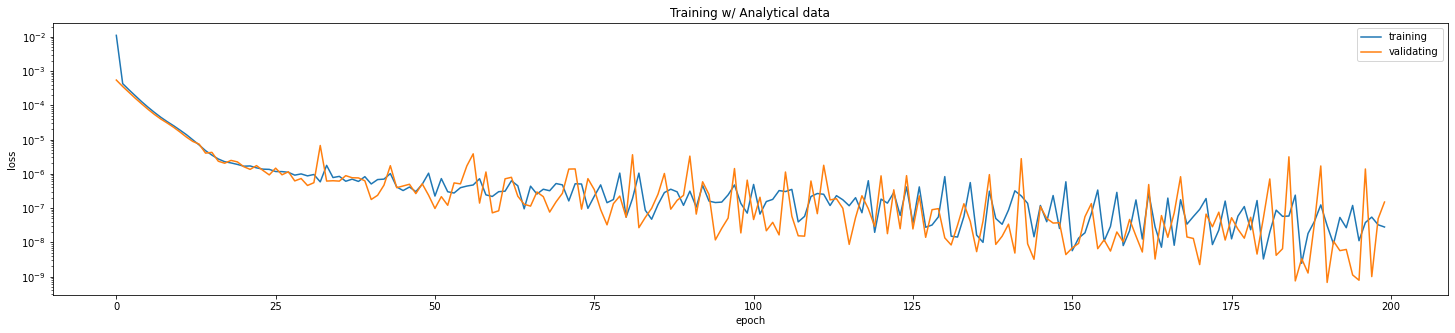

In [62]:

fig,ax = plt.subplots(1,1,figsize=(25,5))
ax.semilogy(historian.history["loss"], label="training")
ax.semilogy(historian.history["val_loss"], label="validating")

plt.title('Training w/ Analytical data')
plt.xlabel('epoch')
plt.ylabel('loss')
ax.legend()



### Testing at another time, same analytical data

loss mean for sample=  4.117315e-07


Text(0, 0.5, 'loss')

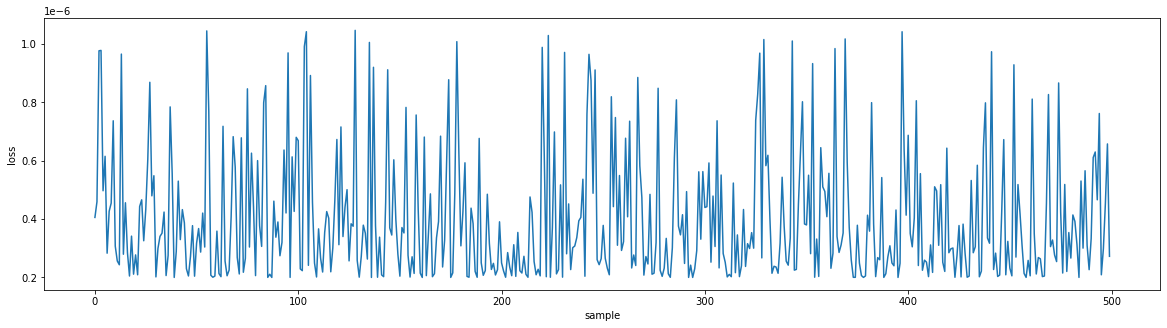

In [50]:
# evaluate on t=1 ie. U_test & Ut_test

U_test = reshape_U(U_exact[:,:,10])
Ut_test = get_Ut(U_exact[:,:,10],U_exact[:,:,11]) 

#Randomize:
U_test , Ut_test = randomize_unision(U_test, Ut_test)

Ut_test_predicted = network(U_test)
loss_test = tf.keras.losses.MSE(Ut_test, Ut_test_predicted).numpy()

print("loss mean for sample= ", "{:e}".format(loss_test.mean()))

fig = plt.subplots(1,1,figsize=(20,5))

plt.plot(loss_test[0:500])
plt.xlabel('sample')
plt.ylabel('loss')
#reme = np.reshape(Ut_test_predicted,(101,101))

#print(reme[1:7,1:7])

# JUMP TO "Let's try the learn operator" to calculate other example with this operator

# FEniCS

#### The code used with FEniCS can be found under "heatequation_fenics/heatequation.ipynb"

In [38]:
%reload_ext autoreload

U_train_f , Ut_train_f = get_FEniCSdata() # Time steps: 0 and 1


U_train_f , Ut_train_f = randomize_unision(U_train_f , Ut_train_f)

Ut shape =  (63001,)
U shape =  (63001, 5)


### Testing on FEniCS - model build with analytical data

loss mean =  2.028378e-06


Text(0, 0.5, 'Loss')

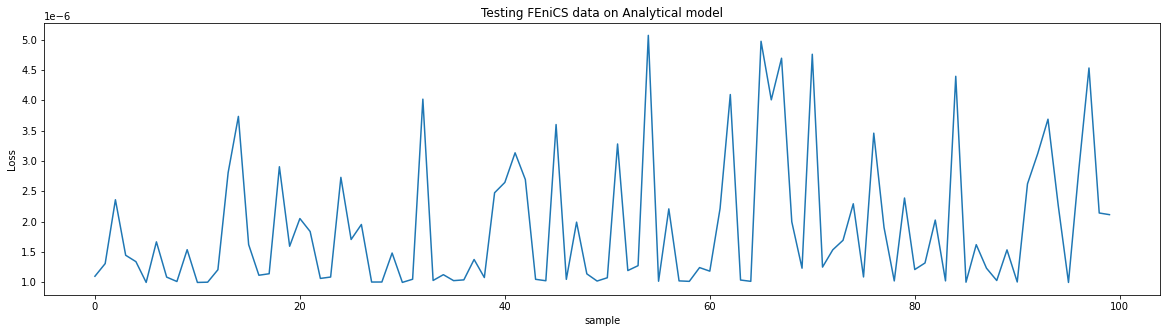

In [55]:
Ut_test_predicted = network(U_train_f[0:1000])

loss_test = tf.keras.losses.MSE(Ut_train_f[0:1000], Ut_test_predicted).numpy()
print("loss mean = ", "{:e}".format(loss_test.mean()))

fig,ax = plt.subplots(1,1,figsize=(20,5))
plt.plot(loss_test[0:100])
plt.title('Testing FEniCS data on Analytical model')
plt.xlabel('sample')
plt.ylabel('Loss')

### Training with FEniCS data

In [40]:

historian = network.fit(U_train_f, Ut_train_f,
                      validation_split=.1, epochs=NET_EPOCHS, verbose=0, batch_size=NET_BATCH_SIZE,
                      callbacks=callbacks)

The average loss for epoch 199 is 0.0000000022 

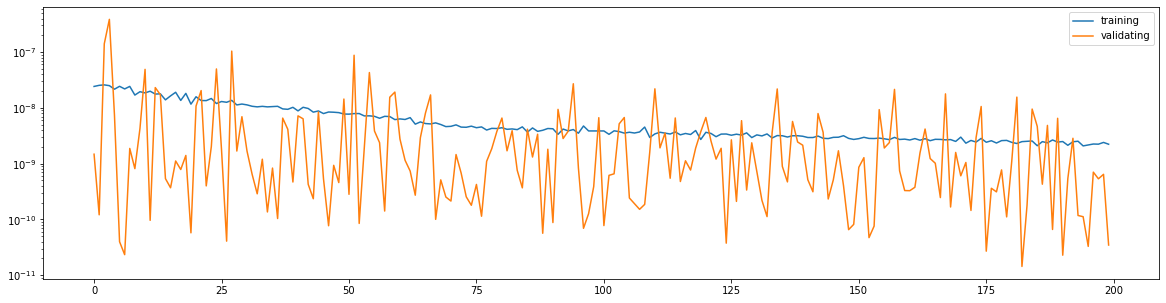

In [41]:
# plot everything

fig,ax = plt.subplots(1,1,figsize=(20,5))
ax.semilogy(historian.history["loss"], label="training")
ax.semilogy(historian.history["val_loss"], label="validating")

x0 = len(historian.history["loss"])*1.1

ax.legend()

# Compare Ut_exact vs Ut_appr

#### Training on Fenics data, at other t

In [13]:
'''
# U_train_f , Ut_train_f = get_FEniCSdata(0,1) # Time steps: 0 and 1
# Ut_train_f , U_train_f = randomize_unision(Ut_train_f , U_train_f)

Ut_test_predicted = network(U_train_f[800:900])

loss_test = tf.keras.losses.MSE(Ut_train_f[800:900], Ut_test_predicted).numpy()
print("loss mean = ", "{:e}".format(loss_test.mean()))

fig,ax = plt.subplots(1,1,figsize=(20,5))
plt.plot(loss_test)
plt.title('Training on FEniCS data')
plt.xlabel('sample')
plt.ylabel('Loss')

'''

'\n# U_train_f , Ut_train_f = get_FEniCSdata(0,1) # Time steps: 0 and 1\n# Ut_train_f , U_train_f = randomize_unision(Ut_train_f , U_train_f)\n\nUt_test_predicted = network(U_train_f[800:900])\n\nloss_test = tf.keras.losses.MSE(Ut_train_f[800:900], Ut_test_predicted).numpy()\nprint("loss mean = ", "{:e}".format(loss_test.mean()))\n\nfig,ax = plt.subplots(1,1,figsize=(20,5))\nplt.plot(loss_test)\nplt.title(\'Training on FEniCS data\')\nplt.xlabel(\'sample\')\nplt.ylabel(\'Loss\')\n\n'

### Applying it to a Gaussian Kernel as IC


#### Initial Conditions
\begin{equation}
        U(x,y,0) =  {e}^ {-\frac{(x-0.5)^2+(y-0.5)^2}{2 \sigma^2}}, \quad \sigma^2 = 0.001
        
\end{equation}

In [63]:
# Defining the initial conditions

sigmasqr = 0.01
n_per_axis = 250
x_axis = np.linspace(0,1, num=n_per_axis + 1)
y_axis = np.linspace(0,1,num=n_per_axis + 1)
#t_axis = np.linspace(0,0.01, num =101)

def initial_conditions(x,y,sigmasqr = sigmasqr):
    return  np.exp(-((x-0.5)**2 + (y-0.5)**2)/(2*sigmasqr))

# Define axis:
x_axis = np.linspace(0,1, num=n_per_axis + 1)
y_axis = np.linspace(0,1,num=n_per_axis + 1)
t_axis = np.linspace(0,0.01, num =101)

xx, yy = np.meshgrid(x_axis, y_axis, sparse=False)
U_gaussian_init =  initial_conditions(xx, yy)

print(U_gaussian_init.shape)


(251, 251)


#### Let's now use the learnt operator



In [64]:

num_t = 500

U_gaussian = np.zeros([n_per_axis+1,n_per_axis+1, num_t])
U_gaussian[:,:,0] =  U_gaussian_init[:,:]
for t in range(num_t-1):
    # Reshaping to use the operator one time
    #print("gaussian pre shape= ", U_gaussian[:,:,t].shape) 
    U_gaussian_test = reshape_U(U_gaussian[:,:,t],n=n_per_axis)
    #print("gaussian_test shape= ", U_gaussian_test.shape) 
    #predicting Ut
    Ut_gaussian_predicted = network(U_gaussian_test)
    #print("Ut_predicted shape", Ut_gaussian_predicted.shape)

    Ut_gaussian_predicted = np.reshape(Ut_gaussian_predicted, (n_per_axis+1,n_per_axis+1))
    # Update the value of U
    #var[t+1] = Ut_gaussian_predicted
    U_gaussian[:,:,t+1] = U_gaussian[:,:,t] + np.transpose(Ut_gaussian_predicted)

print("U_gaussian final shape:", U_gaussian.shape)





U_gaussian final shape: (251, 251, 500)


max t0 0.9830861913521838
min t0 0.003078171929626083


max t20 0.964694608023139
min t20 0.006416822383658379


max t50 0.9119875238143792
min t50 0.01594852542751339


max t100 0.8319116382091617
min t100 0.01058022123613728


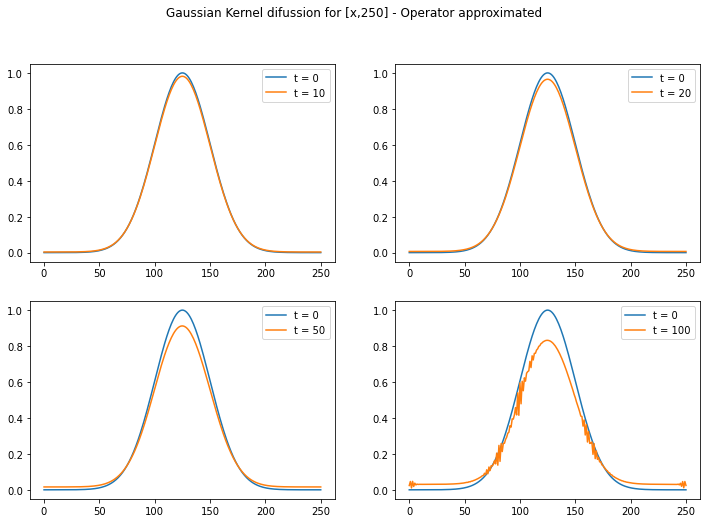

In [93]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12,8))

fig.suptitle('Gaussian Kernel difussion for [x,250] - Operator approximated')

ax1.plot(U_gaussian[:,125,0])
ax1.plot(U_gaussian[:,125,10])
ax1.legend(['t = 0', 't = 10'])

ax2.plot(U_gaussian[:,125,0])
ax2.plot(U_gaussian[:,125,19])
ax2.legend(['t = 0', 't = 20'])

ax3.plot(U_gaussian[:,125,0])
ax3.plot(U_gaussian[:,125,49])
ax3.legend(['t = 0', 't = 50'])

ax4.plot(U_gaussian[:,125,0])
ax4.plot(U_gaussian[:,125,99])
ax4.legend(['t = 0', 't = 100'])


#plt.plot(U_gaussian[125,125,:])
print("max t0", U_gaussian[:,125,9].max())
print("min t0", U_gaussian[:,125,9].min())
print("\n")
print("max t20", U_gaussian[:,125,19].max())
print("min t20", U_gaussian[:,125,19].min())
print("\n")
print("max t50", U_gaussian[:,125,49].max())
print("min t50", U_gaussian[:,125,49].min())
print("\n")
print("max t100", U_gaussian[:,125,99].max())
print("min t100", U_gaussian[:,125,99].min())
